# Vehicle Detection with Enhanced Optical Flow Outlier Filter

**Tobias Augspurger for CarND**

> __**The optical flow on a detected vehicle needs to be equal distibuted.**__ 

This is my final project for the CarND Term 1. The goal is to detect car in a video stream. This is done by and SVC classifier with multiple image features. Densed Optical Flow is later on used to removed outlier by the variance of the pixel angle and speed.

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.set_printoptions(threshold=np.nan)
import cv2
import glob
import time
import pickle
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from utils import *
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage.feature import peak_local_max

## Load Training Data

In [2]:
cars = glob.glob('./train_test_images/vehicles/**/*.png',recursive=True)
notcars = glob.glob('./train_test_images/non-vehicles/**/*.png',recursive=True)

## Display Probes of the Training Data

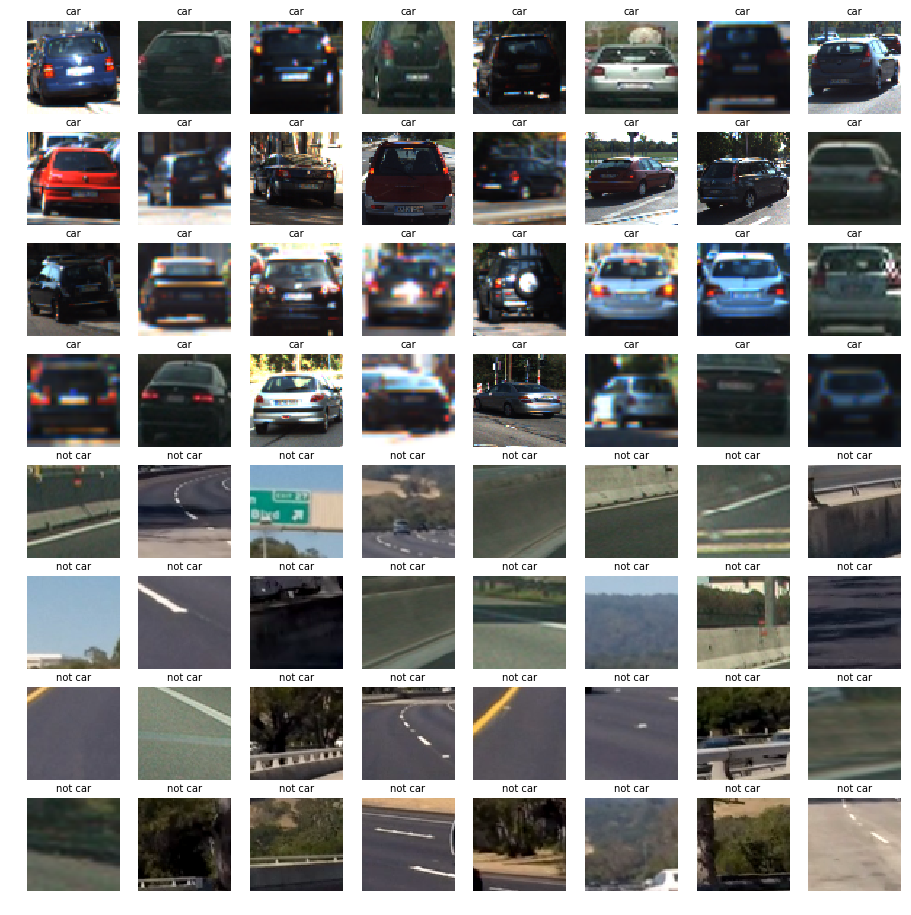

In [3]:
fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in np.arange(32):
    img = cv2.imread(cars[np.random.randint(0,len(cars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(notcars[np.random.randint(0,len(notcars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('not car', fontsize=10)
    axs[i].imshow(img)


## Define a Feature Detector for single windows

In [4]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

## Tuning Classifier Parameters

> Explain how (and identify where in your code) you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters.

The parameters have been tuned to an optimal balance between false positives,true positives and true negatives. After testing all the color spaces from RGB, YCrCb, HSV and YUV, the results in the SVC in prediction step were pointing into the YUV or YCrCb. A YUV classifier could even work later on with a YCrCb image space. In the final video analysis the YCrCb colorspace shows much less false positives in the shadow areas.The performance on the vehicles was not effected by that. For HOG I used all channels and increased the orient, pix_per_block and hist_bins parameters to reduce the number of false positives. Spartial and histogram features are also concatened with HOG, building a larger normalized feature array.

In [5]:
# Reduce the sample size to an equal size
sample_size = 8412
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 14 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

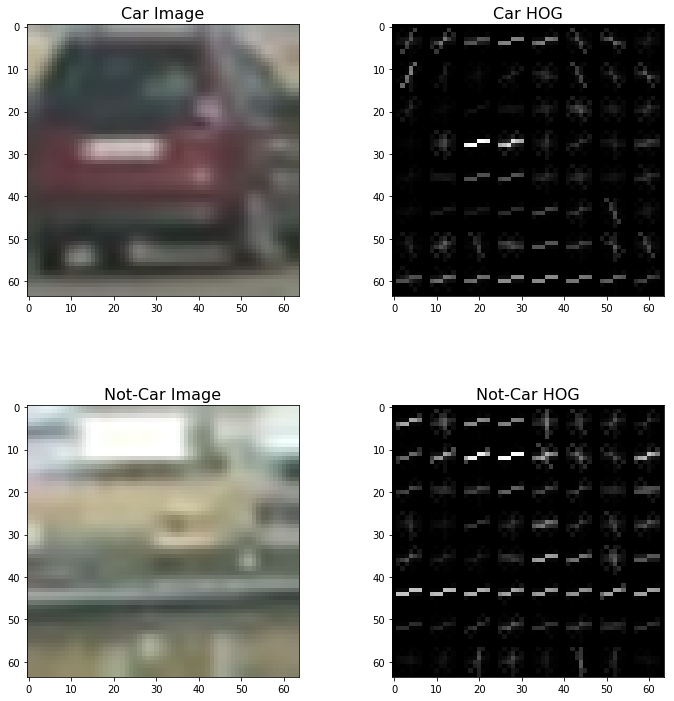

In [6]:
car_img = mpimg.imread(cars[1])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
notcar_img = mpimg.imread(notcars[1])
_, notcar_dst = get_hog_features(notcar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(notcar_img)
ax3.set_title('Not-Car Image', fontsize=16)
ax4.imshow(notcar_dst, cmap='gray')
ax4.set_title('Not-Car HOG', fontsize=16)
plt.show()

## Extracte Features, Train and Test Classifier

> Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

The data is splitted into a traind and validation part. In the next step I scale the data down to a normalized form using:
```
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
```

In line 39 we finally get to the training with a SVC classifier: '
```
svc.fit(X_train, y_train)
```

The results are scored with ```svc.score() ``` showing the prediction with the unseen validation datasets.

In [7]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
filehandler = open('svc.pickel', 'wb')
pickle.dump(svc, filehandler)

Using: 11 orientations 14 pixels per cell and 2 cells per block
Feature vector length: 4356
10.94 Seconds to train SVC...
Test Accuracy of SVC =  0.9816
My SVC predicts:  [ 0.  0.  0.  1.  0.  1.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  0.  1.  0.  1.  0.  0.]
0.00138 Seconds to predict 10 labels with SVC


## Test the Classifier with Search Window
The classifier is tested on a simple image with a sliding window approch. The complete image with no boundings is sampled for that. Since the image is loaded with cv2 we need to transform it from BGR to YCrCb and normalize before processing.

In [15]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='YCrCb', 
                    spatial_size=(64, 64), hist_bins=16, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel="ALL", spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

Load some sample data and run the slide_window() function over it with the just create SVC classifier.

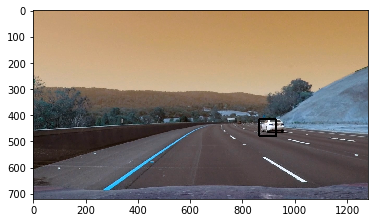

In [9]:
file_pi = open('svc.pickel', 'rb')
svc = pickle.load(file_pi)
y_start_stop = [None, None] # Min and max in y to search in slide_window()

image_raw = cv2.imread('./test_images/test4.jpg')
image = image_raw.astype(np.float32)/255
draw_image = np.copy(image)

image_raw3 = cv2.imread('./test_images/test3.jpg')
image3 = image_raw3.astype(np.float32)/255
draw_image3 = np.copy(image3)

windows = slide_window(image3, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image3, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image3, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.show()

## Sum it up to find_car()
> Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?

Since we do not need to search for cars in the complete image, we focus on the area of the road. This information can later on been extracted from a classifier for the freespace(road_detection) but also from a HDMap. This can help to look only for vehicles in the space that is driveable for us. The function find_car returns the bounding boxes of the windows with vehicles. Overlapping is keeped at 50/50 since this results in low false positives and many true positives.This is shown by the final image with only windows on the vehicles. Also the scale from the example is keeped constant to the quiz example.

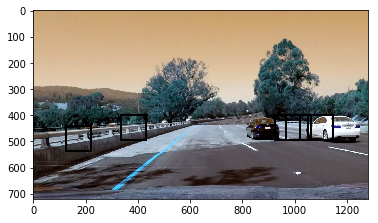

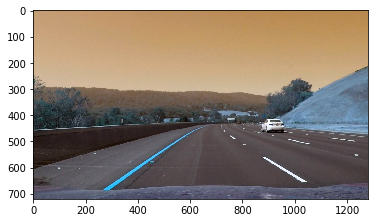

In [10]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    bbox = []
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))       
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)           
    return img, bbox

# Run some sample images
ystart = 400
ystop = 656
scale = 1.5
    
out_img, bbox_list = find_cars(draw_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
out_img3, bbox_list3 = find_cars(draw_image3, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)
plt.show()
plt.imshow(out_img3)
plt.show()

## Final Grid Resolution
The following image shows the grid for the sliding window. The combination of very small and big grid cells showed the best results in detection.

![](examples/grid.png)

> Show some examples of test images to demonstrate how your pipeline is working. How did you optimize the performance of your classifier?

# Densed Optical Flow

The basic idea behind Optical Flow is quite simple. Find feature in two images with a small time delay and measure the movement of features you can detect between both images. This results in a vector representing the speed of the detected feature between two images. The densed optical flow can extracted the speedmap in every pixel area with enough features. Other optical flow methodes like Lucas-Kanade try to estimate the speed of complete objects by detecting corner patterns. For more information please check the OpenCV Tutorial:     
https://www.docs.opencv.org/trunk/d7/d8b/tutorial_py_lucas_kanade.html

The function ```cv2.calcOpticalFlowFarneback``` enables the simple integration of a densed optical flow method. For the calculation of the flow, the next frame in the video stream is used. Leaving out frames can cause very high magnitudes in the flow since the time between the images is higher. Later on the speedmap is used the calculate the variance of flow for a detected car. 

In [11]:
def dense_flow(frame1,nextframe):
    prvs = cv2.cvtColor(frame1,cv2.COLOR_RGB2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[...,1] = 255
    if nextframe != []:
        next = cv2.cvtColor(nextframe,cv2.COLOR_RGB2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 6, 5, 1.2, 0)
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = ang*180/np.pi/2
        hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
        hsv = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    return hsv

The follow picture show the **Optical Densed Flow** in the HSV color space with magnitude and angle. On the right side the flow on the vehicle shows a good feature for detection or outlier filtering:

![examples/densed_flow.png](examples/densed_flow.png)

The mean flow on the vehicle is a sign of the speed of the vehicle. In general the speed will keep low for most of the vehicles, since the relative speed to the camera is low.

## Create the Heat Filter 

For a better statistic, the detected vehicle is summed up over multiple images by the heatmap. This helps to filter outlier, but can reduced the detection rate for true positives. The heatmap is filtered by a threshold. In the bboxes_estimation function the bounding boxes from the find_cars function are combined and filtered. Here is the optical flow integrated into the pipeline. When the variance in speed and angle is zero, the sample windows is removed. Lots of false positives get removed in this way. Another indicator for an outlier is a very high variance of direction over the image. An object like a car should show low variance.

In [12]:
# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above

image_raw = cv2.imread('./test_images/test4.jpg')
draw_image = np.copy(image_raw)
image = image_raw.astype(np.float32)/255
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def heat_threshold(heatmap,threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def bboxes_estimation(img, labels,speedmap,max_var,max_ang,min_samples):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        speed_list = []
        ang_list = []
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Check Optical flow for those pixels
        ########
        if speedmap != []:
            speed = speedmap[nonzero[0],nonzero[1],2]
            ang = speedmap[nonzero[0],nonzero[1],0]
            

            speed_var = np.var(speed)
            ang_var = np.var(ang)
            ang_sum = np.sum(ang)

            #print("Number of Elements")
            #print(len(speed))      
            #print("Var Speed Value")
            #print(speed_var)
            #print("Var Direction Value")
            #print(ang_var)
            #print("Sum Direction Value")
            #print(ang_sum)
            #print("----")
            
            
        if (speed_var != 0 or ang_var != 0) and ang_var < max_var and len(speed)>min_samples:#and ang_sum < max_ang:
        # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
    # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


# Final Pipeline
> Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

The resulting final pipeline combines all functions. It gets as an input the raw images from the video steam and plots the final bounding boxes on it. The heatmap is summed into a limited weighted history. This helps to remove more outliers. The combined heatmap is the reduced to bounding boxes by the label function, representing each detected car until now. This labels are now compared with the speedmap values for this area. If the variance in the direction is to high the label is removed from the list. Also areas with zero variance in magnitude and angle are removed. This helps to remove the last false positives.

In [13]:
speedmap = []
heat_his = []
frame2 = []
frame3 = []
frame4 = []

def pipe_detect(image_raw):
    
    global frame2,frame3,frame4
    global heat_his
    image = image_raw.astype(np.float32)/255
    draw_image = np.copy(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    #Calc Densed Optical Flow 
    speedmap = dense_flow(image_raw,frame2)
    
    # Statistic Parameters
    ystart = 400
    ystop = 656
    scale = 1.5
    threshold = 2
    max_heat_his = 12
    max_var = 140
    max_ang = 200000
    min_samples = 700
    time_weight = 0.6
    
    # Get all bbox from sliding window
    heat_w = np.copy(heat)
    out_img, bbox_list = find_cars(draw_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat = add_heat(heat,bbox_list)
    
    if heat_his != []:
        heat_his.append(heat)
        if len(heat_his) < max_heat_his:
            for i in range(len(heat_his)):
                heat_w = cv2.addWeighted(heat_w, 1, heat_his[i], 1, 0)
        else:
            for i in range(len(heat_his)):
                heat_w = cv2.addWeighted(heat_w, 1, heat_his[i], 1, 0)
            heat_his.pop(0)

        # Apply threshold to help remove false positives
        heat = heat_threshold(heat_w,threshold*(len(heat_his)*time_weight))
        heatmap = np.clip(heat, 0, 255)
        
    else:
        heat_his.append(heat)
        # Visualize the heatmap when displaying    
        heat = heat_threshold(heat,threshold)
        heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = bboxes_estimation(np.copy(image_raw), labels,speedmap,max_var,max_ang,min_samples)
    
    #Viz Data
    #fig = plt.figure()
    #plt.subplot(221)
    #plt.imshow(draw_img)
    #plt.title('Car Positions')
    #plt.subplot(223)
    #plt.imshow(heatmap, cmap='hot')
    #plt.title('Heat Map')
    #if frame2 != []:
    #    plt.subplot(122)
    #    plt.imshow(speedmap)
    #    plt.title('Speed Map')
    #fig.tight_layout()
    #plt.show()
    
    # Store Images for Optical Flow
    frame4 = frame3
    frame3 = frame2
    frame2 = image_raw
    
    return draw_img

pipe_detect(image_raw)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [14]:
speedmap = []
heat_his = []
frame2 = []
frame3 = []
frame4 = []
white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("./project_video.mp4")
# Look at the critical parts
#clip1 = clip1.subclip(30, 31)
white_clip = clip1.fl_image(pipe_detect) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
del white_clip

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [15:57<00:00,  1.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 15min 57s, sys: 16.5 s, total: 16min 13s
Wall time: 15min 59s


## Discussion
> Briefly discuss any problems / issues you faced in your implementation of this project.  

The integration of the classifier was really straight forward with the dataset of udacity. After the integration of the sliding window I worked with very small grid resolution leading to lots of outliers. With higher dimensions of the sliding window the rate of false positives could be reduced, but vehicles in a greater distance could not be detected any more. With smaller and bigger grid cells in combination I was able to detect the vehciles I larger distances. There was also a tradeoff between the number of false postivies and true positives. I some frames the bounding boxes are lost since the outlier detections removes true positives from the heatmap.

> Where will your pipeline likely fail?

My pipeline will fail with fast crosstraffic, since the final heatwindow is based on multiple area based  summed up values that are not tracked over time. Thats why this approch will not work for objects of high speed. Fast rotations in roundabouts can also cause the same problem, since the car is rotating quite fast.

> What could you do to make it more robust?

The integration of a real Kalman filter for tracking in combination with the optical flow could be a huge benefit. Since the speed is known, the state of the detected vehicle can be followed over multiple frames. By the histrogram of the car pixels and speedmap, the car position is predictable in the next image. Another way to improve this pipeline is to integrate a DNN like YOLO for detecting the car. This could be integrated as another find_cars() function delivering more bounding boxes that are matched with the optical flow. The combination of YOLO with the SVC and Densed Optical Flow would be the perfect input for an Kalman Filter.